# Compact Mixed Integer Linear Programming Model for Balancing Bike Sharing Systems 

In [15]:
import gurobipy as gb
import networkx as nx
import pygraphviz as pygv
import os
from IPython.display import SVG, display
import pandas as pd

In [5]:
def draw_initial_graph():
    global DrawG
    scale = 15
    DrawG = pygv.AGraph(strict='true', splines='true')

    for i in G.nodes():
        pos = str(G.node[i]['x'] * scale) + ',' + str((G.node[i]['y']) * scale)

        if G.node[i]['load'] < 0:
            DrawG.add_node(i, shape='circle', pos=pos, label=G.node[i]['label'], color='red',
                           style='filled', fillcolor='salmon', fontsize='8', width='0.3')
        elif G.node[i]['load'] > 0:
            DrawG.add_node(i, shape='circle', pos=pos, label=G.node[i]['label'], color='green',
                           style='filled', fillcolor='palegreen1', fontsize='8', width='0.3')
        else:
            DrawG.add_node(i, shape='circle', pos=pos, label=G.node[i]['label'], fontsize='8', width='0.3')

    DrawG.layout(prog='neato', args='-n')
    DrawG.draw(path=basename + '.svg', format='svg')

## Introduction

//TODO

## Problem Definition

//DA MIGLIORARE <br>
We are given a set of stations S and a set of homogeneous
vehicles L. For the vehicles, we are given a common capacity
Z and a common time budget t̂ (drivers’ shift times) within
which the vehicles have to finish their routes. For each station
s ∈ S we are given the number of full vehicle loads f s to be
delivered (f s ≤ −1) or picked up (f s ≥ 1) such that the station
achieves its (approximately) ideal target fill level. Stations
that are already at their desired target fill level (or require
less than a full vehicle load) are ignored from any further
consideration.

### Graph Definition

//TODO

In [3]:
filename = 'graph.gml'

basename = os.path.splitext(filename)[0]

G = nx.read_graphml (filename, node_type=str)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

print(G.is_directed())

G has 23 nodes and 131 edges
False


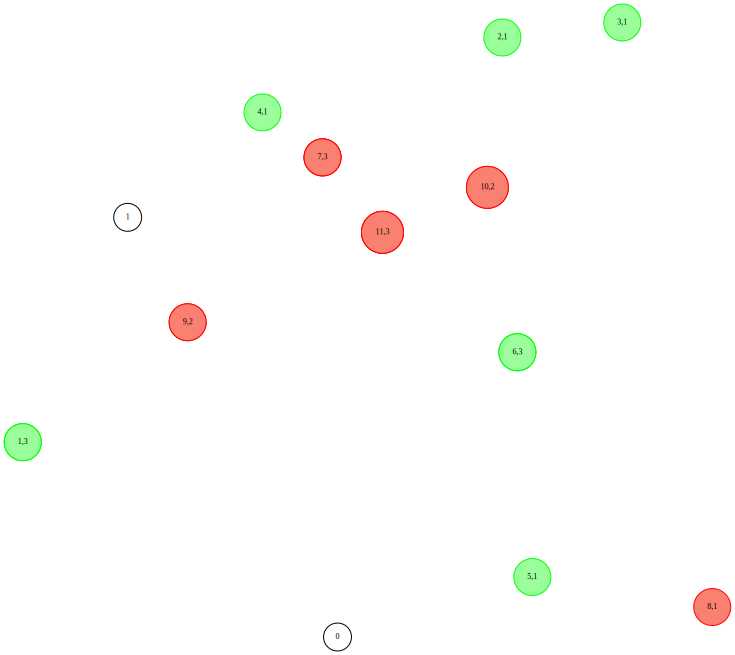

In [6]:
draw_initial_graph()
display(SVG(filename=basename+'.svg'))

In [19]:
pd.DataFrame(G.nodes(data=True))

,0,1
0,"(7, 1)","{'station': 7, 'load': -3, 'label': '7,1', 'x'..."
1,"(7, 2)","{'station': 7, 'load': -3, 'label': '7,2', 'x'..."
2,"(7, 3)","{'station': 7, 'load': -3, 'label': '7,3', 'x'..."
3,"(8, 1)","{'station': 8, 'load': -1, 'label': '8,1', 'x'..."
4,"(9, 1)","{'station': 9, 'load': -2, 'label': '9,1', 'x'..."
5,"(9, 2)","{'station': 9, 'load': -2, 'label': '9,2', 'x'..."
6,"(10, 1)","{'station': 10, 'load': -2, 'label': '10,1', '..."
7,"(10, 2)","{'station': 10, 'load': -2, 'label': '10,2', '..."
8,"(11, 1)","{'station': 11, 'load': -3, 'label': '11,1', '..."
9,"(11, 2)","{'station': 11, 'load': -3, 'label': '11,2', '..."


In [16]:
pd.DataFrame(G.edges(data=True))

,0,1,2
0,"(7, 1)","(1, 1)",{'time': 2758}
1,"(7, 1)","(1, 2)",{'time': 2758}
2,"(7, 1)","(1, 3)",{'time': 2758}
3,"(7, 1)","(2, 1)",{'time': 1442}
4,"(7, 1)","(3, 1)",{'time': 2193}
5,"(7, 1)","(4, 1)",{'time': 500}
6,"(7, 1)","(5, 1)",{'time': 3130}
7,"(7, 1)","(6, 1)",{'time': 1838}
8,"(7, 1)","(6, 2)",{'time': 1838}
9,"(7, 1)","(6, 3)",{'time': 1838}


## Model Formulation

//TODO

In [10]:
mod = gb.Model()

In [21]:
D = G.to_directed()
v = [i for i in range(1,5)]
z = 30
budget = 300000

In [22]:
x = mod.addVars(D.nodes(), v, obj=1, vtype=gb.GRB.BINARY, name='x')
y = mod.addVars(D.edges(), v, vtype=gb.GRB.BINARY, name='y')
a = mod.addVars(D.nodes(), vtype=gb.GRB.CONTINUOUS, name='a')
mod.ModelSense = -1
mod.write('model.lp')